# Project 1
Our project is to uncover the relationship between gold and crypto currencies. Based on the historical relation of gold and inflation, how does gold compare to Bitcoin, Ethereum, Miners, and Fantom coin (FTM) against inflation now. How can we make an educated decision on where to make initial cash investment? In gold or crypto?

In [1]:
import plotly.express as px
import panel as pn
import pandas as pd
import quandl
import os
from pathlib import Path
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import datetime as dt
import numpy as np

import hvplot.pandas
import plotly.express as px

%matplotlib inline

## Pulling Inflation Data from Quandl API

In [2]:
inflation_projection = quandl.get("FRED/PCECTPIMD")
inflation_projection

Value
Date             
2021-01-01    3.4
2022-01-01    2.1
2023-01-01    2.2

In [3]:
inflation_projection_plot = inflation_projection.hvplot.line()
inflation_projection_plot

:Curve   [Date]   (Value)

In [4]:
inflation_hist_df = quandl.get("RATEINF/CPI_USA")
inflation_hist_df

Value
Date               
1913-01-31    9.800
1913-02-28    9.800
1913-03-31    9.800
1913-04-30    9.800
1913-05-31    9.700
...             ...
2021-02-28  263.014
2021-03-31  264.877
2021-04-30  267.054
2021-05-31  269.195
2021-06-30  271.696

[1302 rows x 1 columns]

In [5]:
#inflation_var_hist_df
#inflation_var_hist_df
inflation_hist_df = inflation_hist_df[['Value']]
inflation_hist_pct_df = inflation_hist_df.pct_change()
inflation_hist_pct_df.dropna(inplace=True)
inflation_hist_pct_df

Value
Date                
1913-02-28  0.000000
1913-03-31  0.000000
1913-04-30  0.000000
1913-05-31 -0.010204
1913-06-30  0.010309
...              ...
2021-02-28  0.005474
2021-03-31  0.007083
2021-04-30  0.008219
2021-05-31  0.008017
2021-06-30  0.009291

[1301 rows x 1 columns]

In [6]:
# Rename the column
inflation_hist_pct_df.rename(columns = {"Value": "Inflation Rate"}, inplace = True)
inflation_hist_pct_df

Inflation Rate
Date                      
1913-02-28        0.000000
1913-03-31        0.000000
1913-04-30        0.000000
1913-05-31       -0.010204
1913-06-30        0.010309
...                    ...
2021-02-28        0.005474
2021-03-31        0.007083
2021-04-30        0.008219
2021-05-31        0.008017
2021-06-30        0.009291

[1301 rows x 1 columns]

In [7]:
cumulative_returns = (1 + inflation_hist_pct_df).cumprod() - 1
cumulative_returns_plot = cumulative_returns.hvplot.line()
cumulative_returns_plot

:Curve   [Date]   (Inflation Rate)

In [8]:
# import S&P 500 history data to Pandas
sp500_hist_path = Path("./Resources/sp500-price-history.csv")
sp500_hist_df = pd.read_csv(sp500_hist_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
sp500_hist_df.index = pd.to_datetime(sp500_hist_df.index)
sp500_hist_df.sort_index(inplace=True)

In [9]:
#sp500_var_hist_df 
sp500_hist_df = sp500_hist_df[['Close']]
sp500_hist_pct_df = sp500_hist_df.pct_change()
sp500_hist_pct_df.dropna(inplace=True)
sp500_hist_pct_df

Close
Date                         
1993-02-01 16:00:00  0.007055
1993-02-02 16:00:00  0.002034
1993-02-03 16:00:00  0.010600
1993-02-04 16:00:00  0.004240
1993-02-05 16:00:00 -0.000667
...                       ...
2021-07-26 16:00:00  0.002455
2021-07-27 16:00:00 -0.004558
2021-07-28 16:00:00 -0.000410
2021-07-29 16:00:00  0.004147
2021-07-30 16:00:00 -0.004856

[7178 rows x 1 columns]

In [10]:
# Rename the column
sp500_hist_pct_df.rename(columns = {"Close": "S&P 500"}, inplace = True)
sp500_hist_pct_df

S&P 500
Date                         
1993-02-01 16:00:00  0.007055
1993-02-02 16:00:00  0.002034
1993-02-03 16:00:00  0.010600
1993-02-04 16:00:00  0.004240
1993-02-05 16:00:00 -0.000667
...                       ...
2021-07-26 16:00:00  0.002455
2021-07-27 16:00:00 -0.004558
2021-07-28 16:00:00 -0.000410
2021-07-29 16:00:00  0.004147
2021-07-30 16:00:00 -0.004856

[7178 rows x 1 columns]

In [11]:
cumulative_returns = (1 + sp500_hist_pct_df).cumprod() - 1
cumulative_returns_plot = cumulative_returns.hvplot.line()
cumulative_returns_plot

:Curve   [Date]   (S&P 500)

In [12]:
# import DXY history data to Pandas
dxy_hist_path = Path("./Resources/dxy-price-history.csv")
dxy_hist_df = pd.read_csv(dxy_hist_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
dxy_hist_df.index = pd.to_datetime(dxy_hist_df.index)
dxy_hist_df.sort_index(inplace=True)
dxy_hist_df.head()

Open        High         Low       Close   Adj Close  Volume
Date                                                                          
1971-08-24  117.839996  117.839996  117.839996  117.839996  117.839996     0.0
1971-08-25  117.839996  117.839996  117.839996  117.839996  117.839996     0.0
1971-08-26  117.839996  117.839996  117.839996  117.839996  117.839996     0.0
1971-08-27  117.839996  117.839996  117.839996  117.839996  117.839996     0.0
1971-08-29         NaN         NaN         NaN         NaN         NaN     NaN

In [13]:
# import tether history data to Pandas
tether_hist_path = Path("./Resources/tether-price-history.csv")
tether_hist_df = pd.read_csv(tether_hist_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
tether_hist_df.index = pd.to_datetime(tether_hist_df.index)
tether_hist_df.sort_index(inplace=True)
tether_hist_df.head()

Open     High       Low    Close        Volume    Market Cap
Date                                                                       
2017-08-29  1.00253  1.01681  0.995690  1.00152  1.178964e+08  3.201709e+08
2017-08-30  1.00170  1.00721  0.996119  1.00074  1.367042e+08  3.199817e+08
2017-08-31  1.00006  1.00823  0.999514  1.00312  1.022734e+08  3.202965e+08
2017-09-01  1.00405  1.01373  1.000540  1.00437  1.434681e+08  3.211231e+08
2017-09-02  1.00459  1.04082  0.998739  1.01788  2.954876e+08  3.330269e+08

In [14]:
#import bitcoin daily history data to Pandas
btc_hist_path = Path("./Resources/bitcoin-price-history.csv")

btc_hist_df = pd.read_csv(btc_hist_path, index_col="Date",infer_datetime_format=True, parse_dates=True)
#btc_hist_df["Date"]=btc_hist_df["Date"].astype("datetime")
#btc_hist_df.dtypes
btc_hist_df.index = pd.to_datetime(btc_hist_df.index)
#btc_hist_df.set_index(pd.to_datetime(btc_hist_df.index))
btc_hist_df.sort_index(inplace=True)
btc_hist_df.head()

Open     High      Low    Close  Volume    Market Cap
Date                                                                
2013-07-17  96.7100  99.9700  96.1800  98.5000     0.0  1.120160e+09
2013-07-18  98.5000  98.8000  86.2000  90.5800     0.0  1.050191e+09
2013-07-19  90.0689  95.2001  87.8000  92.1700     0.0  1.035626e+09
2013-07-20  92.0000  93.1000  89.2711  89.3901     0.0  1.051175e+09
2013-07-21  89.8214  91.9500  88.0000  90.7573     0.0  1.025637e+09

In [15]:
# import eth daily history data to Pandas
eth_hist_path = Path("./Resources/ethereum-price-history.csv")
eth_hist_df = pd.read_csv(eth_hist_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
eth_hist_df.index = pd.to_datetime(eth_hist_df.index)
eth_hist_df.sort_index(inplace=True)
eth_hist_df.head()

Open     High      Low    Close        Volume    Market Cap
Date                                                                      
2016-07-25  12.7495  13.8570  12.6838  13.8105  6.168861e+07  1.095915e+09
2016-07-26  13.8361  13.8511  11.7272  11.7632  5.788441e+07  1.056037e+09
2016-07-27  11.9895  13.3119  11.8357  12.9646  8.589149e+07  1.046191e+09
2016-07-28  12.9728  12.9882  12.4927  12.8619  3.914490e+07  1.050281e+09
2016-07-29  12.8436  12.8706  12.5542  12.8162  1.877377e+07  1.046257e+09

In [16]:
# import gld history data to Pandas
gld_hist_path = Path("./Resources/LBMA-GOLD.csv")
gld_hist_df = pd.read_csv(gld_hist_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
gld_hist_df.index = pd.to_datetime(gld_hist_df.index)
gld_hist_df.sort_index(inplace=True)
gld_hist_df.head()

USD (AM)  USD (PM)  GBP (AM)  GBP (PM)  EURO (AM)  EURO (PM)
Date                                                                    
1968-01-02     35.18       NaN    14.641       NaN        NaN        NaN
1968-01-03     35.16       NaN    14.617       NaN        NaN        NaN
1968-01-04     35.14       NaN    14.603       NaN        NaN        NaN
1968-01-05     35.14       NaN    14.597       NaN        NaN        NaN
1968-01-08     35.14       NaN    14.586       NaN        NaN        NaN

## Dollar Index Data

Read the Dollar Index historic closing prices and create a new daily returns DataFrame from the data. 

In [17]:
#dxy_var_hist_df = dxy_hist_df['Close'].var()
#dxy_var_hist_df
dxy_hist_close_df = dxy_hist_df[['Close']]
dxy_hist_pct_df = dxy_hist_close_df.pct_change()
dxy_hist_pct_df.dropna(inplace=True)
dxy_hist_pct_df

Close
Date                
1971-08-25  0.000000
1971-08-26  0.000000
1971-08-27  0.000000
1971-08-29  0.000000
1971-08-30  0.000000
...              ...
2021-07-19  0.002158
2021-07-20  0.000861
2021-07-21 -0.002366
2021-07-22  0.000755
2021-07-23  0.000970

[15496 rows x 1 columns]

In [18]:
# Rename the column
dxy_hist_pct_df.rename(columns = {"Close": "DXY"}, inplace = True)
dxy_hist_pct_df

DXY
Date                
1971-08-25  0.000000
1971-08-26  0.000000
1971-08-27  0.000000
1971-08-29  0.000000
1971-08-30  0.000000
...              ...
2021-07-19  0.002158
2021-07-20  0.000861
2021-07-21 -0.002366
2021-07-22  0.000755
2021-07-23  0.000970

[15496 rows x 1 columns]

In [19]:
cumulative_returns = (1 + dxy_hist_pct_df).cumprod()
cumulative_returns_plot = cumulative_returns.hvplot.line()
cumulative_returns_plot

:Curve   [Date]   (DXY)

## Tether Data

In [20]:
#tether_var_hist_df = tether_hist_df['Close'].var()
#tether_var_hist_df
tether_hist_close_df = tether_hist_df[['Close']]
tether_hist_pct_df = tether_hist_close_df.pct_change()
tether_hist_pct_df.dropna(inplace=True)
tether_hist_pct_df

Close
Date                
2017-08-30 -0.000779
2017-08-31  0.002378
2017-09-01  0.001246
2017-09-02  0.013451
2017-09-03 -0.015375
...              ...
2021-07-24 -0.000300
2021-07-25  0.000000
2021-07-26  0.000000
2021-07-27  0.000000
2021-07-28  0.000000

[1428 rows x 1 columns]

In [21]:
# Rename the column
tether_hist_pct_df.rename(columns = {"Close": "Tether"}, inplace = True)
tether_hist_pct_df

Tether
Date                
2017-08-30 -0.000779
2017-08-31  0.002378
2017-09-01  0.001246
2017-09-02  0.013451
2017-09-03 -0.015375
...              ...
2021-07-24 -0.000300
2021-07-25  0.000000
2021-07-26  0.000000
2021-07-27  0.000000
2021-07-28  0.000000

[1428 rows x 1 columns]

In [22]:
cumulative_returns = (1 + tether_hist_pct_df).cumprod()
cumulative_returns_plot = cumulative_returns.hvplot.line()
cumulative_returns_plot

:Curve   [Date]   (Tether)

## Bitcoin Returns

Read the Bitcoin historic closing prices and create a new daily returns DataFrame from the data.

In [23]:
#btc_var_hist_df = btc_hist_df['Close'].var()
#btc_var_hist_df
btc_hist_close_df = btc_hist_df[['Close']]
btc_hist_pct_df = btc_hist_close_df.pct_change()
btc_hist_pct_df.dropna(inplace=True)

In [24]:
# Rename the column
btc_hist_pct_df.rename(columns = {"Close": "BTC"}, inplace = True)
btc_hist_pct_df

BTC
Date                
2013-07-18 -0.080406
2013-07-19  0.017554
2013-07-20 -0.030161
2013-07-21  0.015295
2013-07-22  0.009395
...              ...
2021-07-19 -0.030209
2021-07-20 -0.035395
2021-07-21  0.080074
2021-07-22  0.006086
2021-07-23  0.036104

[2928 rows x 1 columns]

In [26]:
cumulative_returns = (1 + btc_hist_pct_df).cumprod()
cumulative_returns_plot = cumulative_returns.hvplot.line()
cumulative_returns_plot

:Curve   [Date]   (BTC)

## Ethereum Returns

Read the Ethereum historic closing prices and create a new daily returns DataFrame from the data. 

In [27]:
#eth_var_hist_df = eth_hist_df['Close'].var()
#eth_var_hist_df
eth_hist_close_df = eth_hist_df[['Close']]
eth_hist_pct_df = eth_hist_close_df.pct_change()
eth_hist_pct_df.dropna(inplace=True)

In [28]:
# Rename the column
eth_hist_pct_df.rename(columns = {"Close": "ETH"}, inplace = True)
eth_hist_pct_df

ETH
Date                
2016-07-26 -0.148242
2016-07-27  0.102132
2016-07-28 -0.007922
2016-07-29 -0.003553
2016-07-30 -0.026506
...              ...
2021-07-19 -0.040577
2021-07-20 -0.020670
2021-07-21  0.116298
2021-07-22  0.017032
2021-07-23  0.049886

[1824 rows x 1 columns]

In [29]:
cumulative_returns = (1 + eth_hist_pct_df).cumprod()
cumulative_returns_plot = cumulative_returns.hvplot.line()
cumulative_returns_plot

:Curve   [Date]   (ETH)

## Gold Returns

Read the Gold historic closing prices and create a new daily returns DataFrame from the data.

In [30]:
#gld_var_hist_df = gld_hist_df['Close'].var()
#gld_var_hist_df
gld_hist_df = gld_hist_df[['USD (PM)']]
gld_hist_pct_df = gld_hist_df.pct_change()
gld_hist_pct_df.dropna(inplace=True)
gld_hist_pct_df

USD (PM)
Date                
1968-04-02 -0.010610
1968-04-03  0.008043
1968-04-04 -0.017287
1968-04-05  0.001353
1968-04-08  0.001351
...              ...
2021-06-24 -0.003768
2021-06-25  0.001008
2021-06-28 -0.003554
2021-06-29 -0.013958
2021-06-30  0.004386

[13467 rows x 1 columns]

In [31]:
# Rename the column
gld_hist_pct_df.rename(columns = {"USD (PM)": "Gold"}, inplace = True)
gld_hist_pct_df

Gold
Date                
1968-04-02 -0.010610
1968-04-03  0.008043
1968-04-04 -0.017287
1968-04-05  0.001353
1968-04-08  0.001351
...              ...
2021-06-24 -0.003768
2021-06-25  0.001008
2021-06-28 -0.003554
2021-06-29 -0.013958
2021-06-30  0.004386

[13467 rows x 1 columns]

In [32]:
cumulative_returns = (1 + gld_hist_pct_df).cumprod()
cumulative_returns_plot = cumulative_returns.hvplot.line()
cumulative_returns_plot

:Curve   [Date]   (Gold)

## Combine Returns 

In [33]:
# Concatenate btc and dxy dataframes into one dataframe
df_daily_btc_dxy = pd.concat([btc_hist_pct_df, dxy_hist_pct_df], axis = "columns", join = "inner")
df_daily_btc_dxy

BTC       DXY
Date                          
2013-07-18 -0.080406  0.001330
2013-07-19  0.017554 -0.002898
2013-07-21  0.015295  0.000000
2013-07-22  0.009395 -0.004359
2013-07-23  0.043101 -0.002554
...              ...       ...
2021-07-19 -0.030209  0.002158
2021-07-20 -0.035395  0.000861
2021-07-21  0.080074 -0.002366
2021-07-22  0.006086  0.000755
2021-07-23  0.036104  0.000970

[2437 rows x 2 columns]

In [34]:
# Concatenate eth and dxy dataframes into one dataframe
df_daily_eth_dxy = pd.concat([eth_hist_pct_df, dxy_hist_pct_df], axis = "columns", join = "inner")
df_daily_eth_dxy

ETH       DXY
Date                          
2016-07-26 -0.148242 -0.001336
2016-07-27  0.102132 -0.001132
2016-07-28 -0.007922 -0.003194
2016-07-29 -0.003553 -0.012508
2016-07-31 -0.048772  0.000000
...              ...       ...
2021-07-19 -0.040577  0.002158
2021-07-20 -0.020670  0.000861
2021-07-21  0.116298 -0.002366
2021-07-22  0.017032  0.000755
2021-07-23  0.049886  0.000970

[1516 rows x 2 columns]

In [35]:
# Concatenate gold and dxy dataframes into one dataframe
df_daily_gold_dxy = pd.concat([gld_hist_pct_df, dxy_hist_pct_df], axis = "columns", join = "inner")
df_daily_gold_dxy

Gold       DXY
Date                          
1971-08-25 -0.009954  0.000000
1971-08-26 -0.018003  0.000000
1971-08-27 -0.020952  0.000000
1971-08-31 -0.011430 -0.011626
1971-09-01  0.011070  0.000944
...              ...       ...
2021-06-24 -0.003768  0.000218
2021-06-25  0.001008 -0.000109
2021-06-28 -0.003554  0.000762
2021-06-29 -0.013958  0.001850
2021-06-30  0.004386  0.004237

[12529 rows x 2 columns]

In [36]:
# Concatenate all dataframes into one dataframe
df_daily = pd.concat([btc_hist_pct_df, eth_hist_pct_df, gld_hist_pct_df, tether_hist_pct_df, dxy_hist_pct_df], axis = "columns", join = "inner")
df_daily

BTC       ETH      Gold    Tether       DXY
Date                                                        
2017-08-30 -0.001676  0.019166 -0.007697 -0.000779  0.005739
2017-08-31  0.029838  0.012526  0.002484  0.002378 -0.002261
2017-09-01  0.037148  0.011736  0.006594  0.001246  0.001511
2017-09-05  0.037953  0.060779  0.001838 -0.025540 -0.005387
2017-09-06  0.047633  0.066569  0.001722  0.000856 -0.000217
...              ...       ...       ...       ...       ...
2021-06-24  0.027765  0.008622 -0.003768  0.000067  0.000218
2021-06-25 -0.083048 -0.083234  0.001008 -0.000153 -0.000109
2021-06-28 -0.004046  0.056421 -0.003554  0.000000  0.000762
2021-06-29  0.040688  0.039348 -0.013958  0.000100  0.001850
2021-06-30 -0.021762  0.051414  0.004386  0.000167  0.004237

[949 rows x 5 columns]

# Conduct Quantitative Analysis

In this section, you will calculate and visualize performance and risk metrics for the portfolios.

<AxesSubplot:xlabel='Date'>

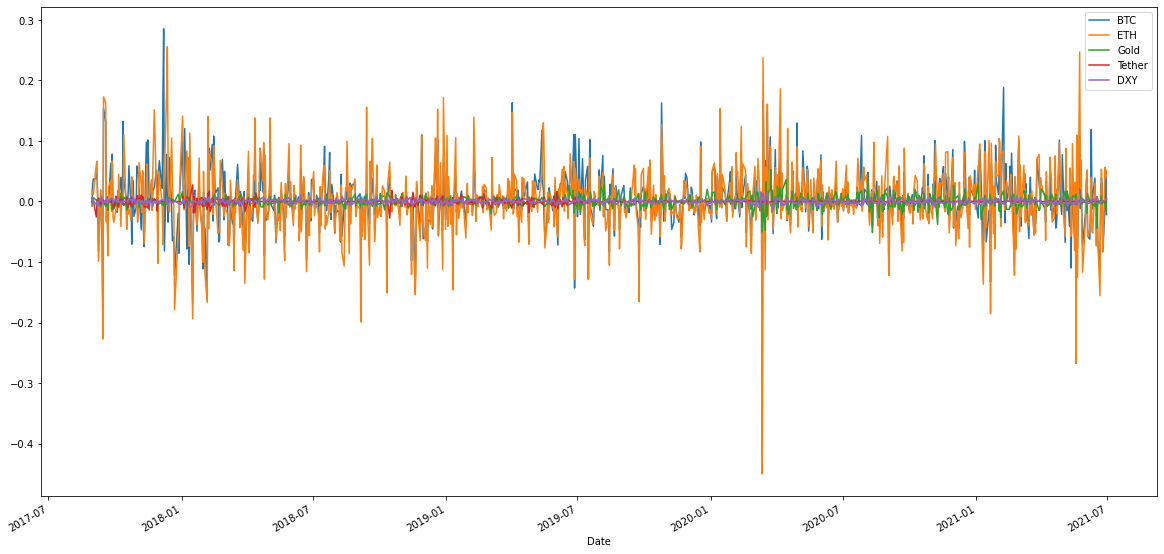

In [37]:
# Plot daily returns
df_daily.plot(figsize = (20,10))

<AxesSubplot:>

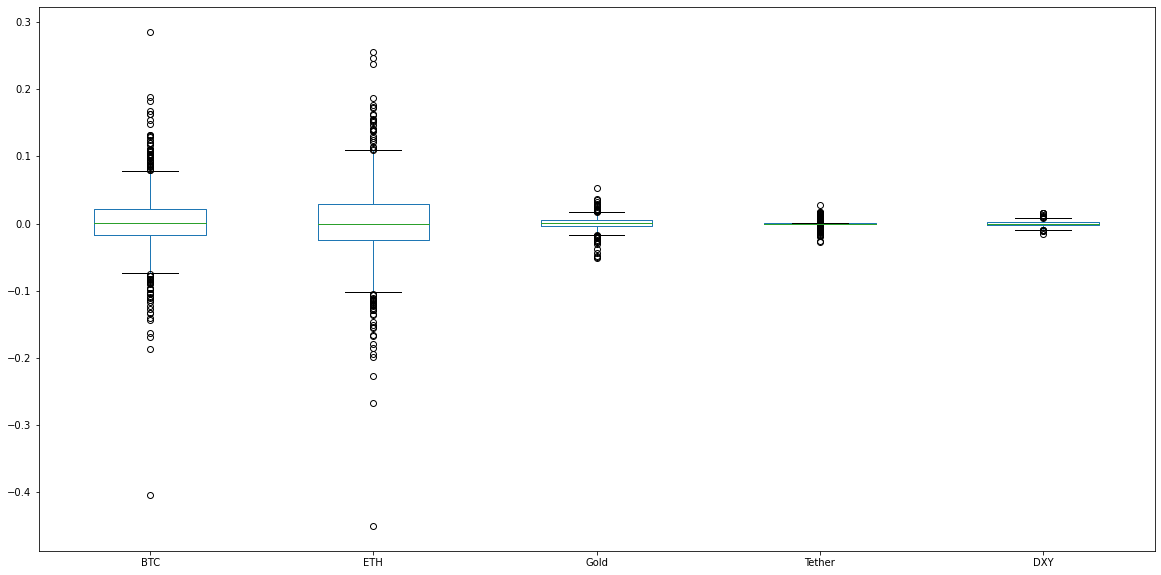

In [38]:
# Box plot to visually illustrate risk
df_daily.plot(kind = "box", figsize = (20, 10))

In [39]:
# Plot cumulative returns of btc compared to dxy
df_cum = (1 + df_daily_btc_dxy).cumprod()
df_cum.hvplot(figsize = (20, 10))

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [40]:
# Plot cumulative returns of eth compared to dxy
df_cum = (1 + df_daily_eth_dxy).cumprod()
df_cum.hvplot(figsize = (20, 10))

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [41]:
# Plot cumulative returns of gld compared to dxy
df_cum = (1 + df_daily_gold_dxy).cumprod()
df_cum.hvplot(figsize = (20, 10))

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [42]:
# Plot cumulative returns
df_cum = (1 + df_daily).cumprod()
df_cum.hvplot(figsize = (20, 10))

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

### Calculate Standard Deviations

In [43]:
# Calculate std for each asset
df_daily_std = pd.DataFrame(df_daily.std()).rename(columns = {0:"std"})
df_daily_std

std
BTC     0.046650
ETH     0.056512
Gold    0.008931
Tether  0.003697
DXY     0.003698

In [44]:
# Determine which portfolio is more risky than dxy
higher_std = df_daily_std[df_daily_std["std"] > df_daily_std.loc["DXY", "std"]]
higher_std

std
BTC   0.046650
ETH   0.056512
Gold  0.008931

In [45]:
# Calculate annualized std
df_annualized_std = df_daily_std*np.sqrt(252)
df_annualized_std

std
BTC     0.740550
ETH     0.897096
Gold    0.141769
Tether  0.058681
DXY     0.058702

In [46]:
# Calculate and plot rolling std for dxy for 21 day period
dxy_rolling_21 = df_daily[["DXY"]].rolling(window=21).std()
dxy_rolling_21.hvplot(figsize = (20, 10))

:Curve   [Date]   (DXY)

### Calculate and plot the correlation

In [47]:
correlation_dxy = pd.DataFrame(df_daily.corr()).loc[:, "DXY"]
correlation_dxy [correlation_dxy==correlation_dxy[correlation_dxy<1].max()]

Tether   -0.030141
Name: DXY, dtype: float64

In [48]:
df_daily.hvplot(kind="scatter", y = "BTC", x = "DXY", title= "BTC vs DXY", figsize = (20, 10))

:Scatter   [DXY]   (BTC)

In [49]:
df_daily.hvplot(kind="scatter", y = "ETH", x = "DXY", title= "ETH vs DXY", figsize = (20, 10))

:Scatter   [DXY]   (ETH)

In [50]:
df_daily.hvplot(kind="scatter", y = "Gold", x = "DXY", title= "Gold vs DXY", figsize = (20, 10))

:Scatter   [DXY]   (Gold)

### Calculate and Plot Beta for a chosen chosen asset compared to DXY

In [51]:
# Calculate Beta for bitcoin compared to dxy
rolling_covariance = df_daily['BTC'].rolling(window=60).cov(df_daily['DXY'])
rolling_variance = df_daily['DXY'].rolling(window=60).var()
rolling_beta = rolling_covariance / rolling_variance
rolling_beta.hvplot(figsize=(20, 10), title = 'Rolling 60 day beta of Bitcoin comapred to DXY')

:Curve   [Date]   (0)

In [52]:
# Calculate Beta for tether compared to dxy
rolling_covariance = df_daily['Tether'].rolling(window=60).cov(df_daily['DXY'])
rolling_variance = df_daily['DXY'].rolling(window=60).var()
rolling_beta = rolling_covariance / rolling_variance
rolling_beta.hvplot(figsize=(20, 10), title = 'Rolling 60 day beta of Tether comapred to DXY')

:Curve   [Date]   (0)

In [53]:
# Calculate Beta for eth compared to dxy
rolling_covariance = df_daily['ETH'].rolling(window=60).cov(df_daily['DXY'])
rolling_variance = df_daily['DXY'].rolling(window=60).var()
rolling_beta = rolling_covariance / rolling_variance
rolling_beta.hvplot(figsize=(20, 10), title = 'Rolling 60 day beta of ETH compared to DXY')

:Curve   [Date]   (0)

In [54]:
# Calculate Beta for gold compared to dxy
rolling_covariance = df_daily['Gold'].rolling(window=60).cov(df_daily['DXY'])
rolling_variance = df_daily['DXY'].rolling(window=60).var()
rolling_beta = rolling_covariance / rolling_variance
rolling_beta.hvplot(figsize=(20, 10), title = 'Rolling 60 day beta of Gold comapred to DXY')

:Curve   [Date]   (0)

In [55]:
df_daily_ewm = df_daily.ewm(span = 21, adjust=False).mean()
(1 + df_daily_ewm).cumprod().hvplot(figsize=(20, 10))

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

# Sharpe Ratios
In reality, investment managers and institutional investors look at the ratio of return-to-risk, and not just the rate of return. When given the opportunity, if you could invest in one of two portfolios, and each offered the same 10% return, yet one offered lower risk, which one would you take?

In [56]:
# Annualized sharpe ratios
sharpe_ratios = df_daily.mean()*252/(df_daily.std()*np.sqrt(252))
sharpe_ratios

BTC       0.975890
ETH       0.475993
Gold      0.560437
Tether   -0.484811
DXY       0.147619
dtype: float64

In [57]:
sharpe_ratios.hvplot(kind = "bar", title = "Sharpe Ratios")

:Bars   [index]   (0)